Estimation error analysis
=========================

_1 August 2021_ <br />
_Chuan-Zheng Lee <czlee@stanford.edu>_ <br />
_Rough working_

This is an effort to analyse whether a reduction in estimation error is in fact responsible for an improvement in learning, using the code added in commit [`95fc23e`](https://github.com/czlee/jadeite/commit/95fc23e7038920e999c0cd2ceac8b478fa3e5d8a).

In [1]:
import json
import numpy as np
import pandas as pd
import re
from pathlib import Path

import matplotlib.pyplot as plt

from plots_utils import get_args, make_axes, plot_averaged_training_charts, plot_comparison, show_timestamp_info

In [2]:
analog_path = Path("results/20210730-estimation-error-dynpower")
digital_path = Path("results/20210730-estimation-error-dynquant")

In [3]:
show_timestamp_info(analog_path)

| experiments in this directory | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **30 Jul 2021, 06:00:03** | 30 Jul 2021, 06:51:42 | 51 min 38 s |
| last to finish | 31 Jul 2021, 22:19:02 | **31 Jul 2021, 23:07:20** | 48 min 18 s |
| shortest | 31 Jul 2021, 22:19:02 | 31 Jul 2021, 23:07:20 | **48 min 18 s** |
| longest | 30 Jul 2021, 06:00:03 | 30 Jul 2021, 06:51:42 | **51 min 38 s** |


# First inspection

Analog:

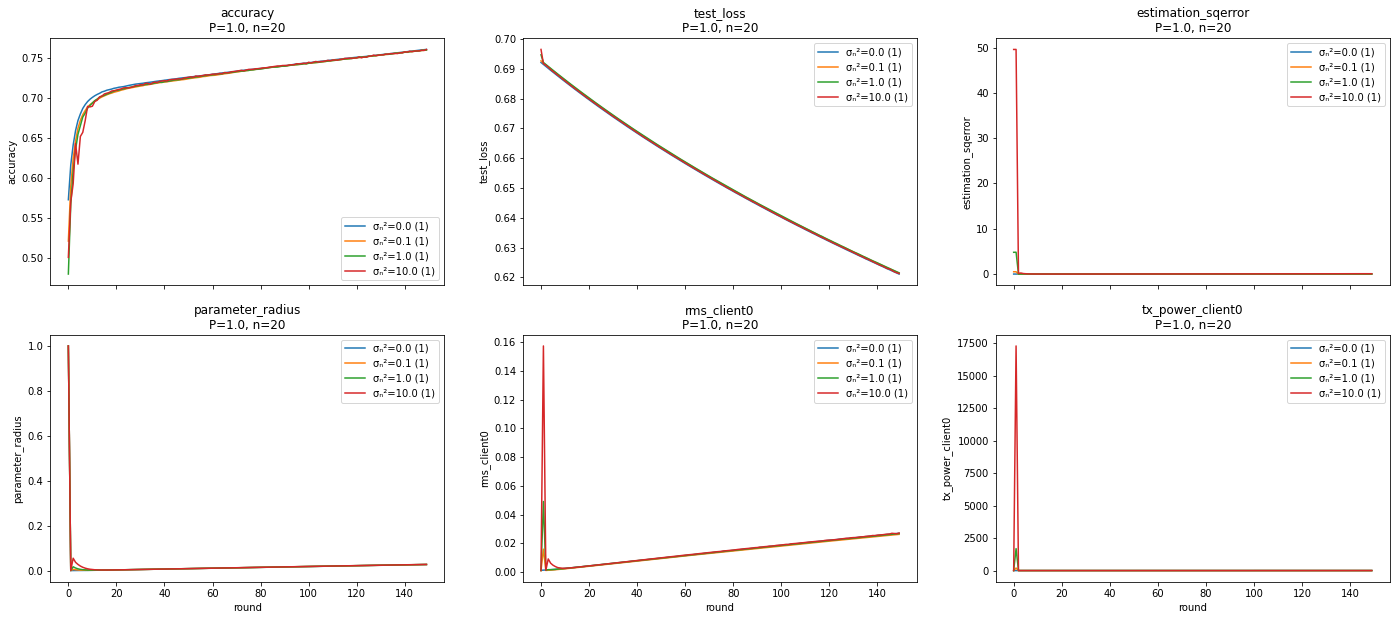

In [4]:
fixed_specs = {
    'rounds': 150,
    'batch_size': 64,
    'lr_client': 0.01,
    'momentum_client': 0.0,
    'epochs': 1,
    'dataset': 'epsilon',
    'ema_coefficient': 1 / 3,
    'power_update_period': 1,
    'power_quantile': 0.9,
    'power_factor': 0.9,
    'data_per_client': None,
    'save_squared_error': True,
    'send': 'deltas',
}
title_specs = {
    'power': 1.0,
    'clients': 20,
}
series_specs = {
    'noise': '__all__',
}
fields = ['accuracy', 'test_loss', 'estimation_sqerror', 'parameter_radius', 'rms_client0', 'tx_power_client0']

plot_averaged_training_charts(analog_path, fields, title_specs, fixed_specs, series_specs)

(0.0, 2.0)

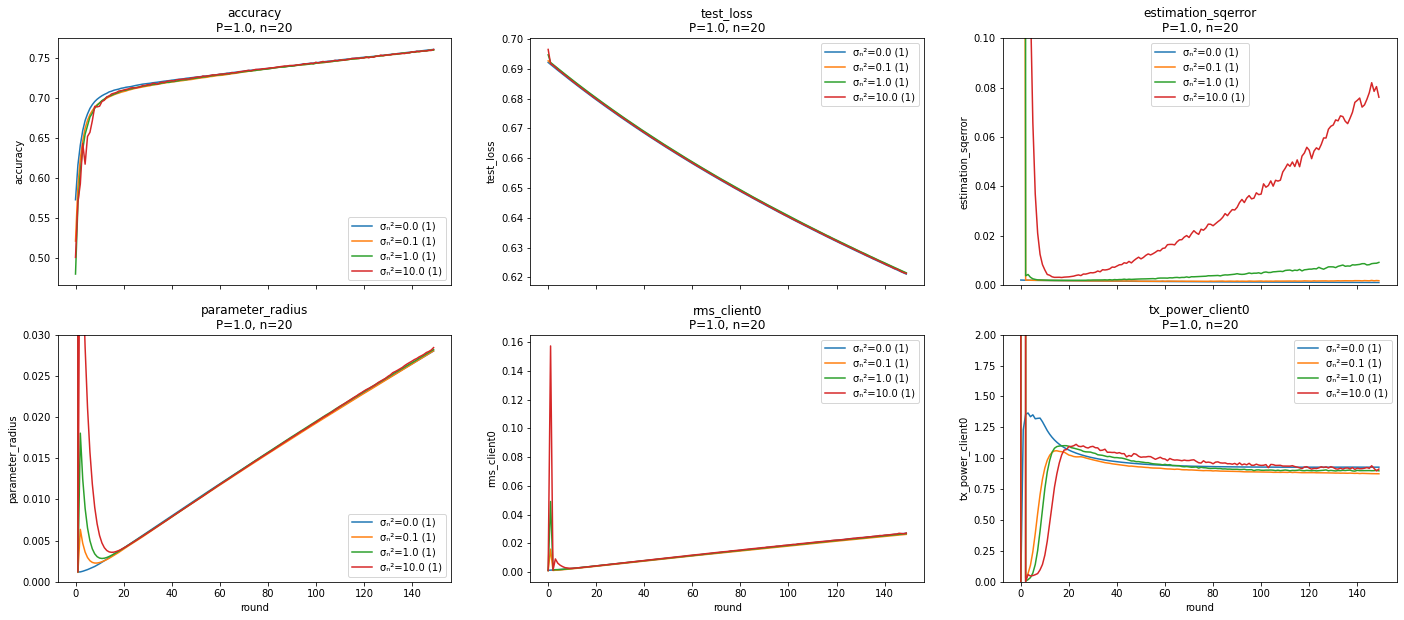

In [5]:
plot_averaged_training_charts(analog_path, fields, title_specs, fixed_specs, series_specs)
axs = plt.gcf().axes
axs[2].set_ylim((0.0, 0.1))
axs[3].set_ylim((0.0, 0.03))
axs[5].set_ylim((0.0, 2.0))

Digital:

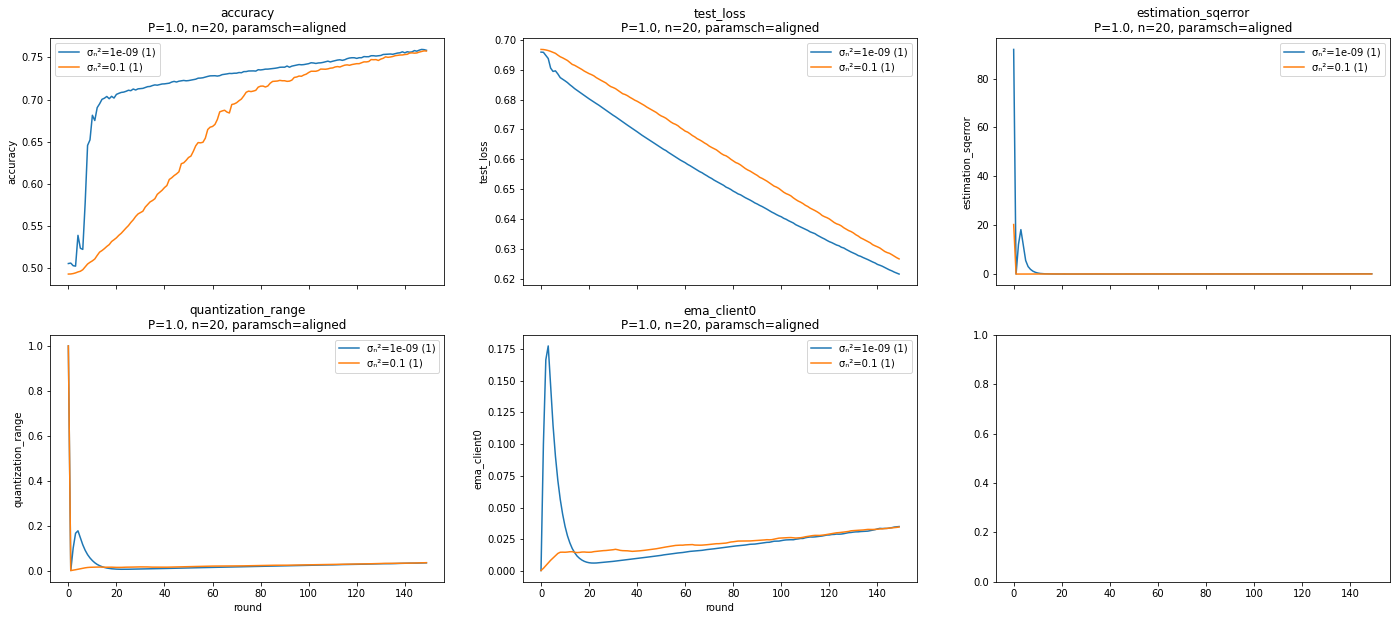

In [6]:
fixed_specs = {
    'rounds': 150,
    'batch_size': 64,
    'lr_client': 0.01,
    'momentum_client': 0.0,
    'epochs': 1,
    'dataset': 'epsilon',
    'ema_coefficient': 1 / 3,
    'qrange_update_period': 1,
    'qrange_param_quantile': 0.9,
    'qrange_client_quantile': 0.9,
    'data_per_client': None,
    'channel_uses': None,
    'rounding_method': 'stochastic',
    'zero_bits_strategy': 'read-zero',
    'send': 'deltas',
    'save_squared_error': True,
}
title_specs = {
    'power': 1.0,
    'clients': 20,
    'parameter_schedule': 'aligned',
}
series_specs = {
    'noise': '__all__',
}
fields = ['accuracy', 'test_loss', 'estimation_sqerror', 'quantization_range', 'ema_client0']

plot_averaged_training_charts(digital_path, fields, title_specs, fixed_specs, series_specs)

(0.0, 0.3)

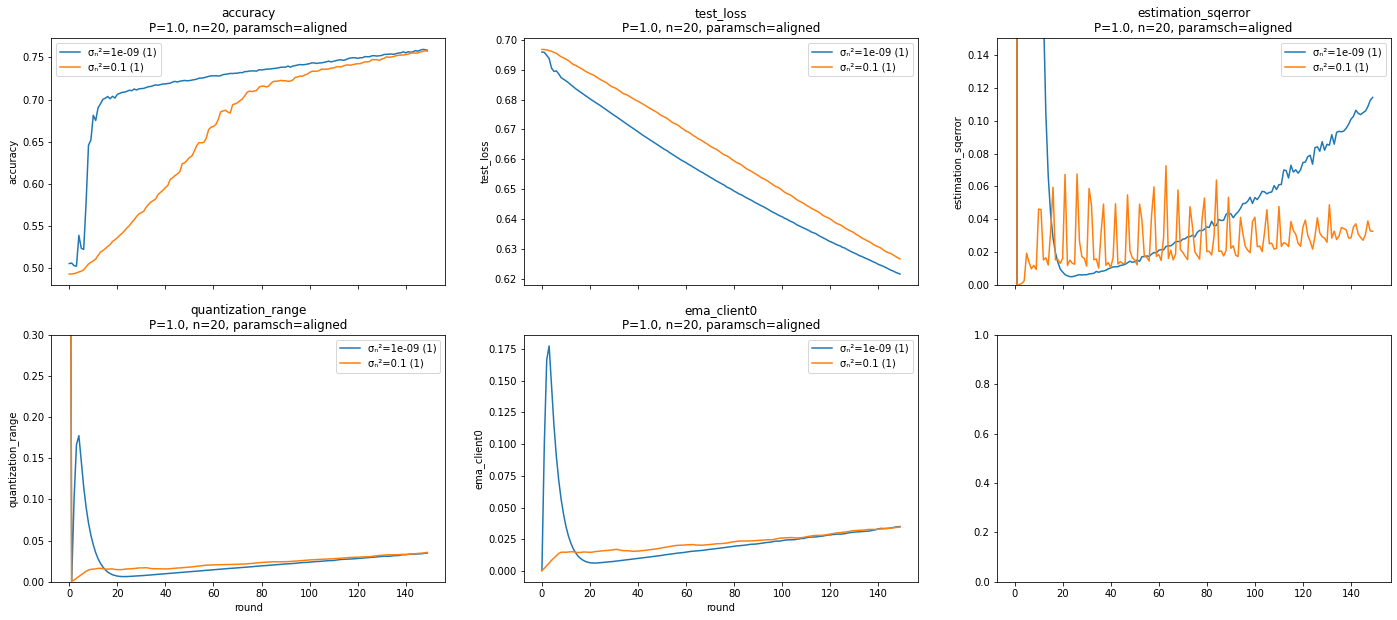

In [7]:
plot_averaged_training_charts(digital_path, fields, title_specs, fixed_specs, series_specs)
axs = plt.gcf().axes
axs[2].set_ylim((0.0, 0.15))
axs[3].set_ylim((0.0, 0.3))

Observations:

1. The estimation error for the digital scheme is in fact higher. I wouldn't necessarily call the correlation between loss reduction and estimation error one-to-one, but you also wouldn't necessarily expect it to be.

2. Comparing the different noise levels for the analog scheme should probably set aside the hypothesis that there is a direct correlation between estimation error and learning progress, at least measured by accuracy or test loss.

3. For some reason, whenever there is nonzero noise, the estimation error in the first two rounds—and only the first two rounds—is much higher than the third round onwards. But we can also see that when there is zero noise in the analog scheme, this error drops to zero. Why does this phenomenon occur _only_ with the first two rounds?

# Inspecting model parameters

In [8]:
def get_model_params(directory, nrounds=150, reference=False):
    model_params = pd.DataFrame(index=range(nrounds), columns=list(range(2000)) + ['weight_norm', 'bias'])
    pattern = "reference_model_at_(\d+).json" if reference else "model_at_(\d+).json"
    for child in directory.iterdir():
        m = re.match(pattern, child.name)
        if not m:
            continue
        r = int(m.group(1))
        if r > nrounds:
            continue
        with open(child) as f:
            model_dict = json.load(f)
        weights = np.array(model_dict['stack.0.weight']).flatten()
        norm = np.linalg.norm(weights, ord=2)
        bias = model_dict['stack.0.bias'][0]
        model_params.loc[r] = np.concatenate((weights, [norm, bias]))
    return model_params

def plot_model_params(directory, nrounds=5, elements=range(100)):
    args = get_args(directory)
    title = f"noise = {args['noise']}"
    if 'parameter_schedule' in args:
        title += f", ps={args['parameter_schedule']}"
    model_params = get_model_params(directory, nrounds=nrounds, reference=False)
    axs = make_axes(4, ncols=2)
    model_params.loc[:nrounds, ['weight_norm', 'bias']].plot(title=title, xlabel="round", ax=axs[0])
    model_params.loc[:nrounds, elements].plot(title="individual elements", legend=False, ax=axs[1])
    model_params = get_model_params(directory, nrounds=nrounds, reference=True)
    model_params.loc[:nrounds, ['weight_norm', 'bias']].plot(title="reference, " + title, xlabel="round", ax=axs[2])
    model_params.loc[:nrounds, elements].plot(title="reference, individual elements", legend=False, ax=axs[3])

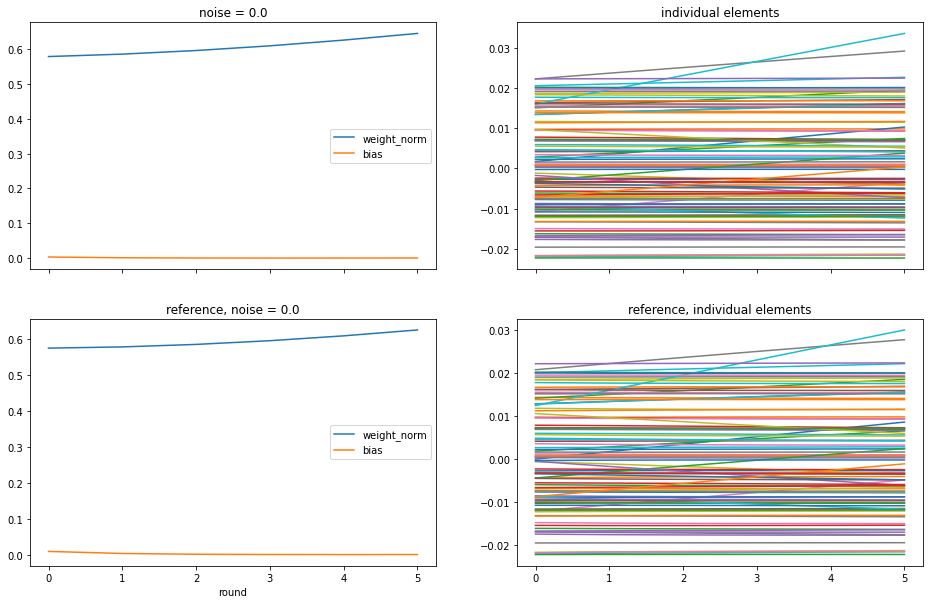

In [9]:
plot_model_params(analog_path / "20210730-054916/clients-20-noise-0.0-iteration-0")

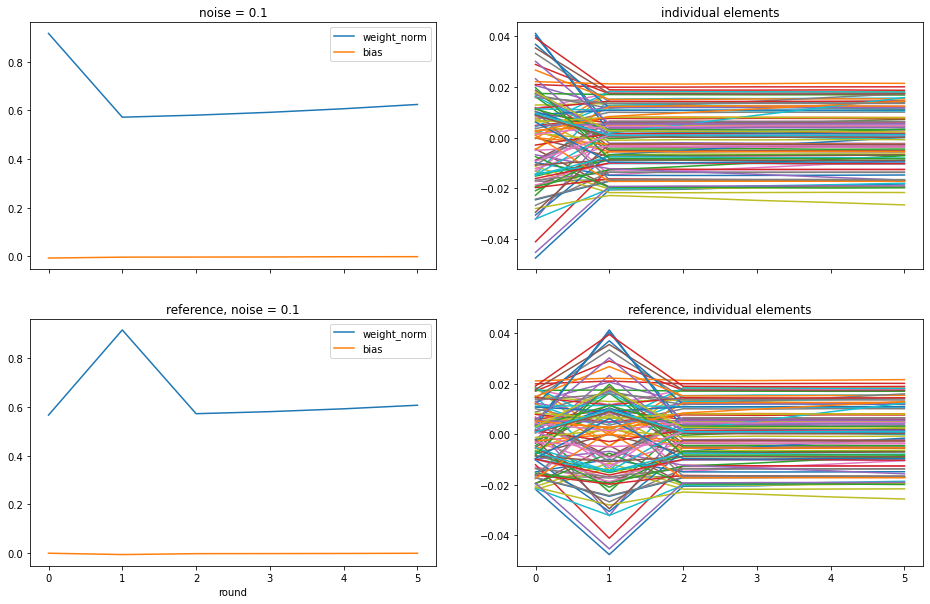

In [10]:
plot_model_params(analog_path / "20210730-054916/clients-20-noise-0.1-iteration-0")

So for the weights it's just an initial jump. But again, it only happens on the first iteration, and it only happens with noise. Why?

The "reference" plot is what the model would have been had it been trained on all the data in a centralized manner. I'm guessing that weird spike in round 1 is a consequence of the initial jumble in round 0, and then it corrects itself in round 2.

Could it just be due to the dynamic power scaling? Does this happen with the non-dynamic scheme as well?

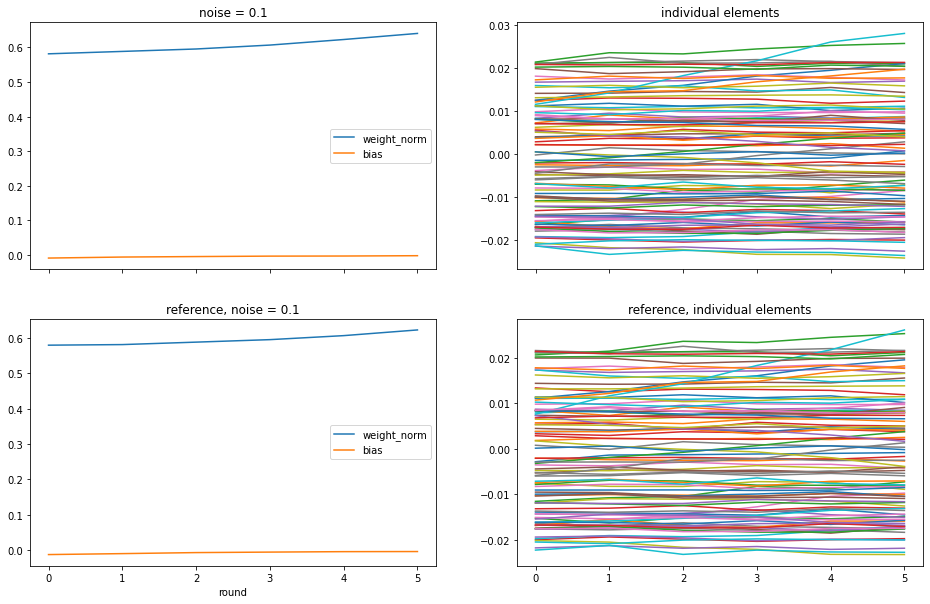

In [11]:
plot_model_params(Path("results/20210731-estimation-error-overtheair/20210731-201759/clients-20-noise-0.1-iteration-0/"))

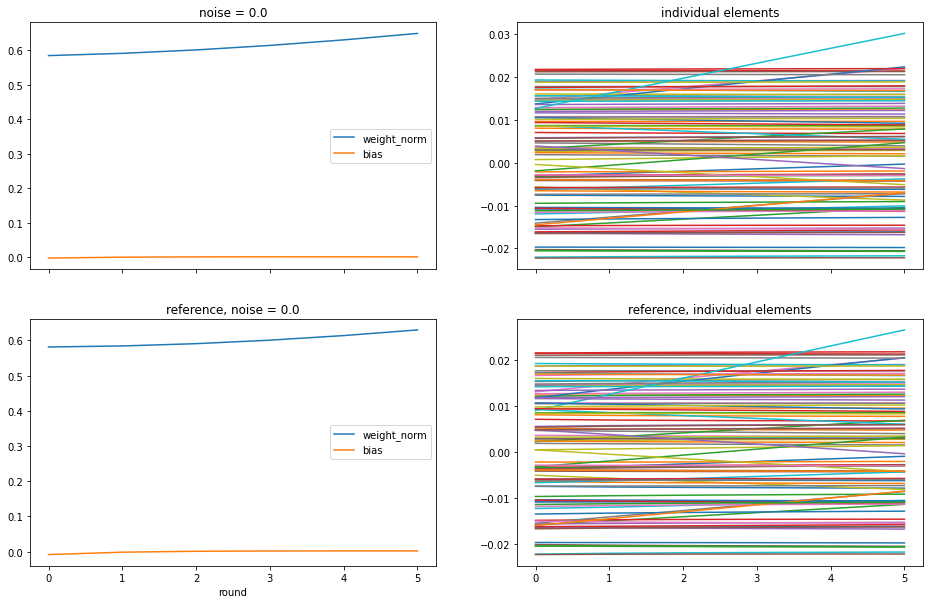

In [12]:
plot_model_params(Path("results/20210731-estimation-error-overtheair/20210731-201759/clients-20-noise-0.0-iteration-0/"))

Okay, seems like there's a good chance it's due to the huge parameter radius initialization.

How about digital? Dynamic:

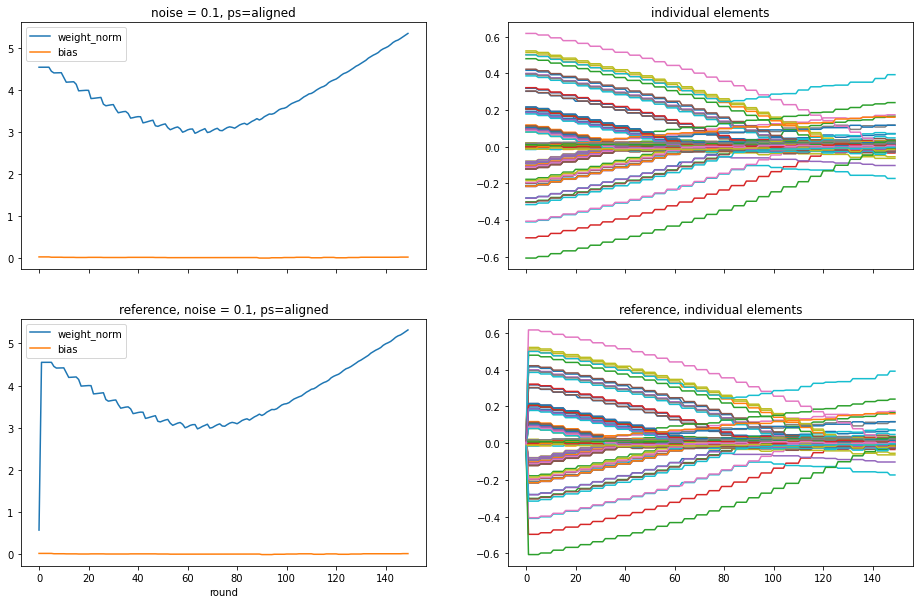

In [13]:
plot_model_params(Path("results/20210730-estimation-error-dynquant/20210730-175500/clients-20-noise-0.1-iteration-0/"), nrounds=150)

Static:

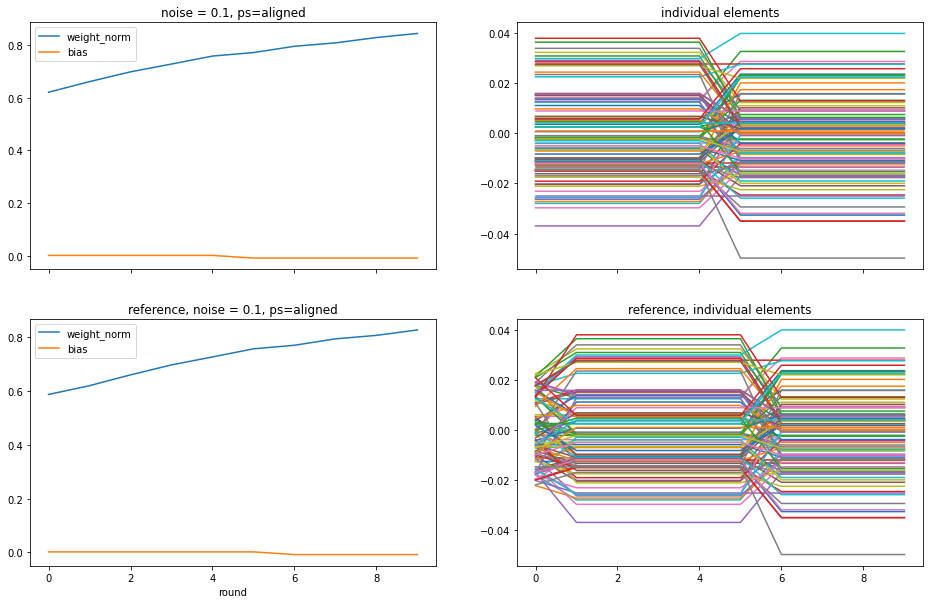

In [14]:
plot_model_params(Path("results/20210731-estimation-error-stocquant/20210731-201825/clients-20-noise-0.1-iteration-0/"), nrounds=10)

Not really so much. Notice that all those elements only change in round 5—I think that's due to the parameter rotation. Quick check:

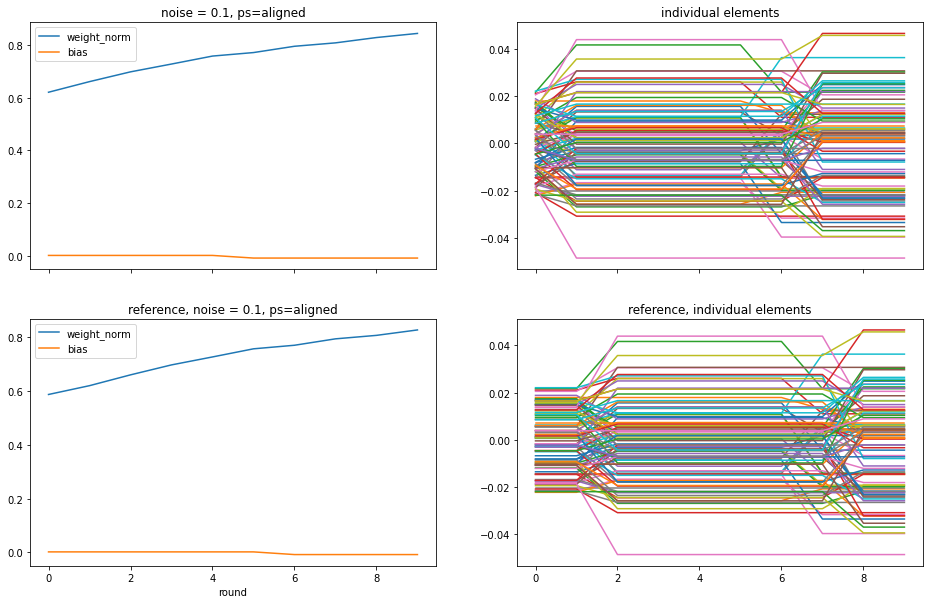

In [15]:
plot_model_params(Path("results/20210731-estimation-error-stocquant/20210731-201825/clients-20-noise-0.1-iteration-0/"), nrounds=10, elements=range(650, 750))

Verify that staggered parameter schedule is as expected:

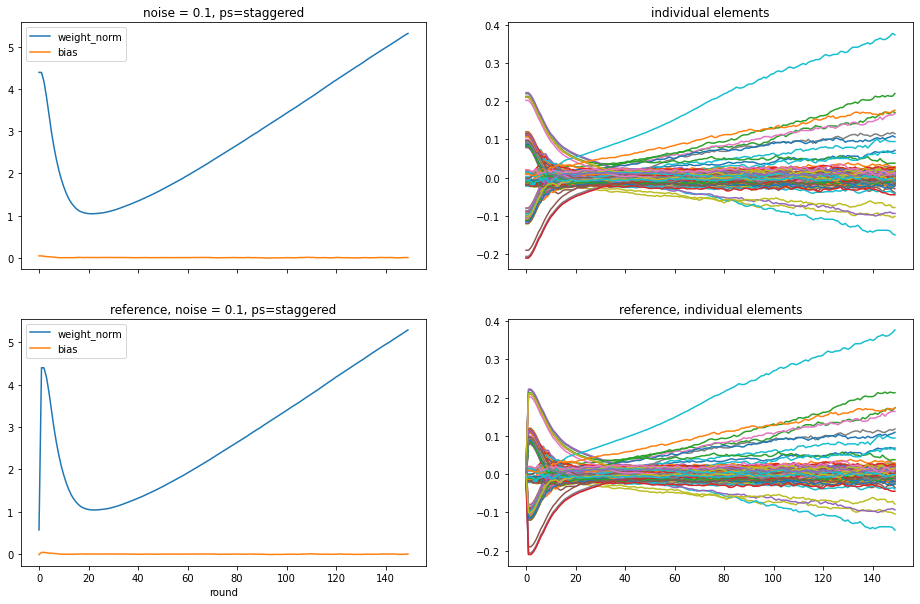

In [16]:
plot_model_params(Path("results/20210730-estimation-error-dynquant/20210731-205410/clients-20-noise-0.1-iteration-0/"), nrounds=150)

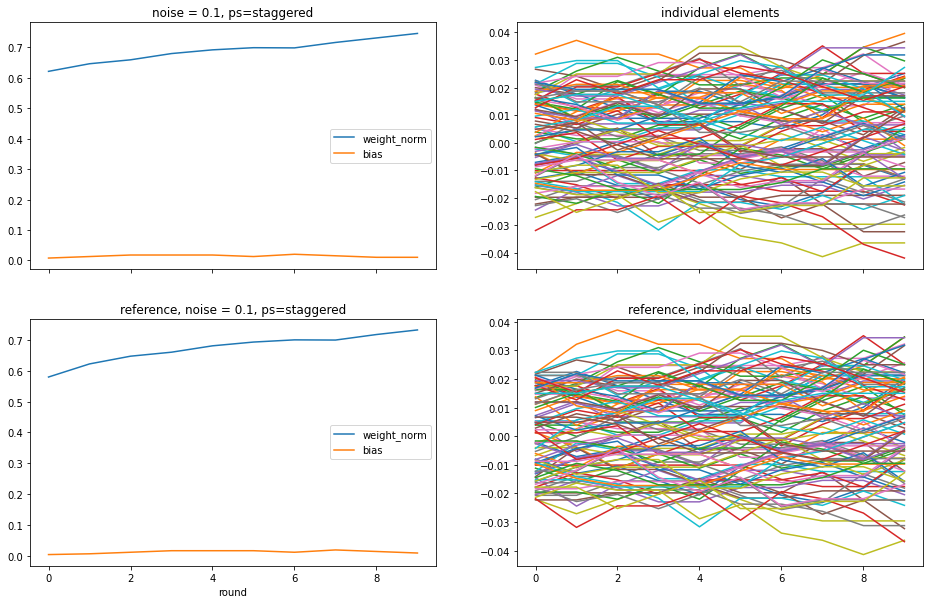

In [17]:
plot_model_params(Path("results/20210731-estimation-error-stocquant/20210731-205450/clients-20-noise-0.1-iteration-0/"), nrounds=10)

Yeah, much more gradual / less stepped.